<a href="https://colab.research.google.com/github/ykato27/AutoML-Time-Series/blob/main/Auto_TS_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install auto-ts

     |████████████████████████████████| 90 kB 3.4 MB/s 
     |████████████████████████████████| 1.5 MB 29.0 MB/s 
     |████████████████████████████████| 1.0 MB 40.1 MB/s 
     |████████████████████████████████| 22.3 MB 43.4 MB/s 
     |████████████████████████████████| 119 kB 72.0 MB/s 
     |████████████████████████████████| 9.5 MB 42.1 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1
  Attempting uninstall: dask
    Found existing installation: dask 2.12.0
    Uninstalling dask-2.12.0:
      Successfully uninstalled dask-2.12.0


In [2]:
import os
import sys

import pandas as pd

dev = False  # Set to false when using production version of library
if dev:
    # Path to Dev version of autots library
    sys.path.append(os.environ["DEV_AUTOTS"])
    %load_ext autoreload
    %autoreload 2

from auto_ts import auto_timeseries

Imported auto_timeseries version:0.0.37. Call by using:
model = auto_timeseries(score_type='rmse',
                time_interval='M',
                non_seasonal_pdq=None, seasonality=False, seasonal_period=12,
                model_type=['best'],
                verbose=2)
model.fit(traindata, ts_column,target)
model.predict(testdata, model='best')



## Load Dataset

In [3]:
file_path = (
    "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
)
dataset = pd.read_csv(file_path, engine="python")
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Month       144 non-null    object
 1   Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [4]:
dataset.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


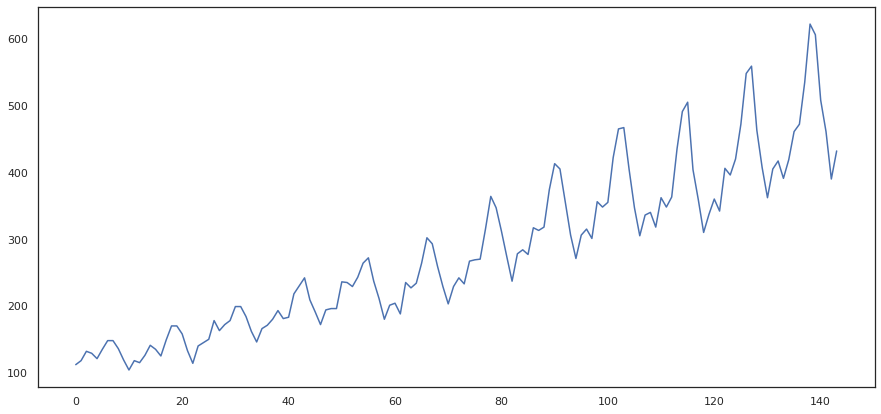

In [5]:
dataset["Passengers"].plot(figsize=(15, 7))

In [6]:
dataset = dataset.set_index(pd.to_datetime(dataset.pop("Month")))
dataset

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


In [7]:
dataset = dataset.resample("QS").sum()

In [8]:
dataset = dataset.reset_index()
dataset.head()

,Month,Passengers
0,1949-01-01,362
1,1949-04-01,385
2,1949-07-01,432
3,1949-10-01,341
4,1950-01-01,382


## Train Model

In [9]:
ts_column = "Month"
target = "Passengers"
sep = ","

In [10]:
FORECAST_PERIOD = 2

In [11]:
model = auto_timeseries(
    score_type="rmse",
    time_interval="QS",
    non_seasonal_pdq=None,
    seasonality=False,
    seasonal_period=12,
    model_type="best",
    verbose=2,
)

Start of Fit.....
Running Augmented Dickey-Fuller test with paramters:
    maxlag: 31 regression: c autolag: BIC
Error: Stationary test failed. Data must be np.array. Check your input and try stationary test again
    Target variable given as = Passengers
Start of loading of data.....
Input is data frame. Performing Time Series Analysis
ts_column: Month sep: , target: Passengers
    Loaded pandas dataframe...
    pandas Dataframe loaded successfully. Shape of data set = (48, 1)


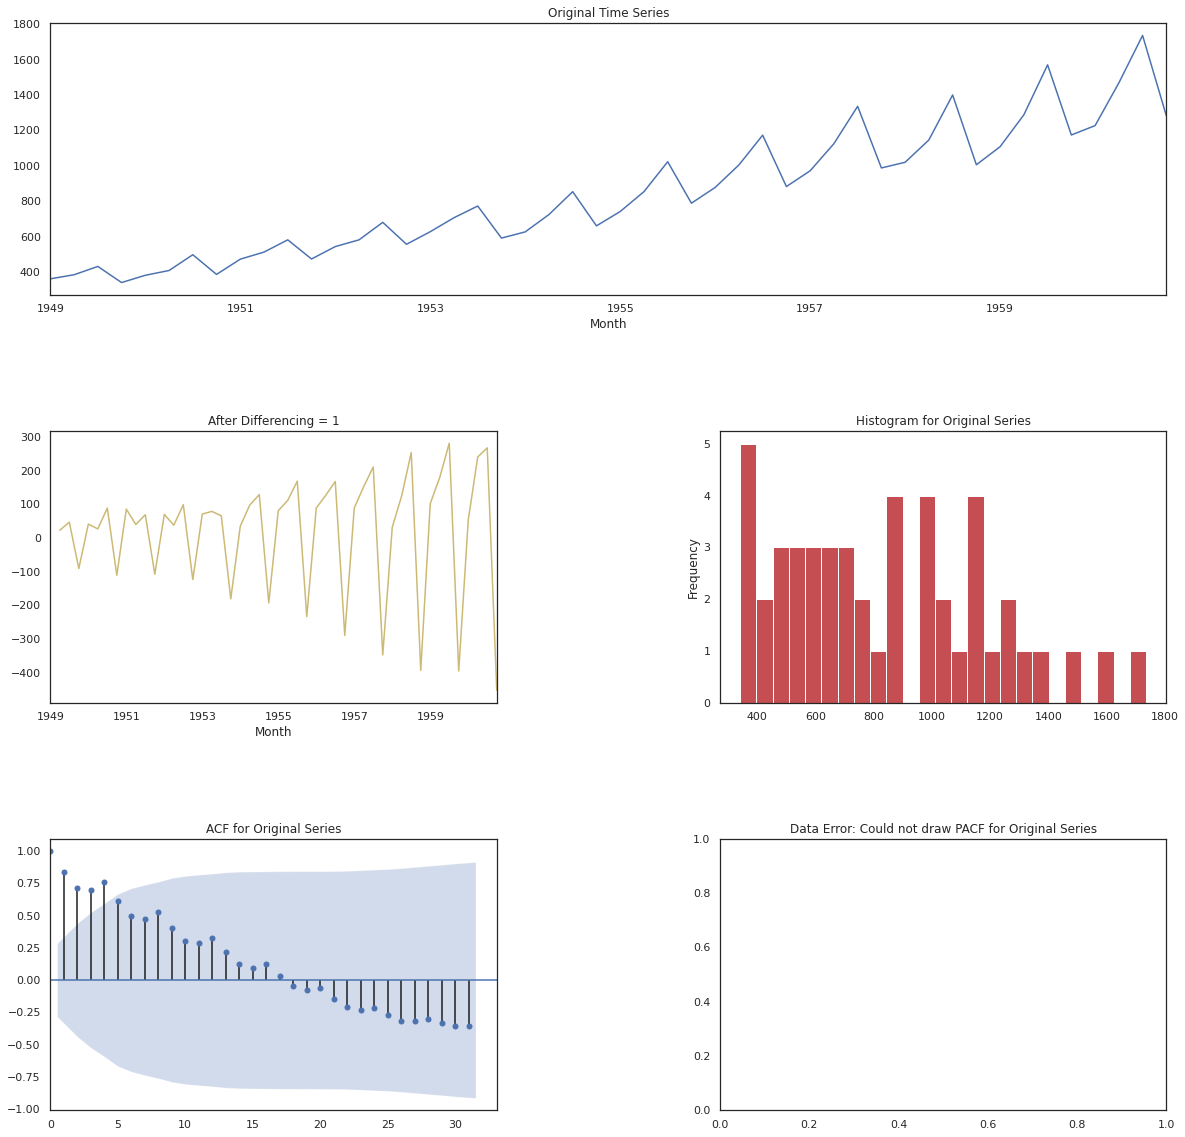

Time Interval is given as QS
    Correct Time interval given as a valid Pandas date-range frequency...


Building Prophet Model



Running Facebook Prophet Model...
    Fit-Predict data (shape=(48, 2)) with Confidence Interval = 0.95...
  Starting Prophet Fit
      No seasonality assumed since seasonality flag is set to False
  Starting Prophet Cross Validation
Max. iterations using expanding window cross validation = 3

Fold Number: 1 --> Train Shape: 33 Test Shape: 5
    Root Mean Squared Error predictions vs actuals = 87.05
    Std Deviation of actuals = 122.26
    Normalized RMSE = 71%
Cross Validation window: 1 completed

Fold Number: 2 --> Train Shape: 38 Test Shape: 5
    Root Mean Squared Error predictions vs actuals = 118.55
    Std Deviation of actuals = 201.53
    Normalized RMSE = 59%
Cross Validation window: 2 completed

Fold Number: 3 --> Train Shape: 43 Test Shape: 5
    Root Mean Squared Error predictions vs actuals = 102.20
    Std Deviation of actuals = 204.80
    Nor

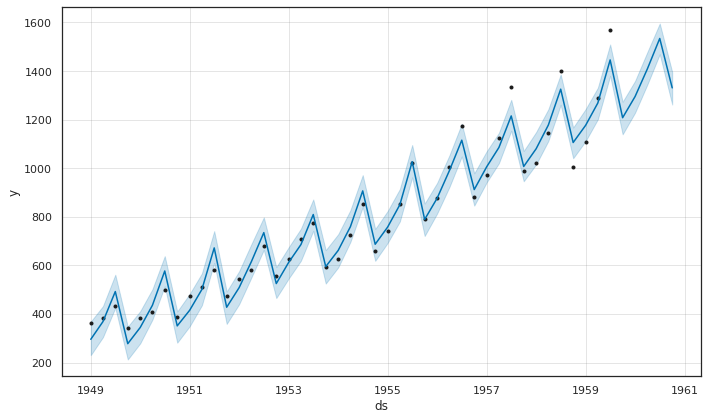

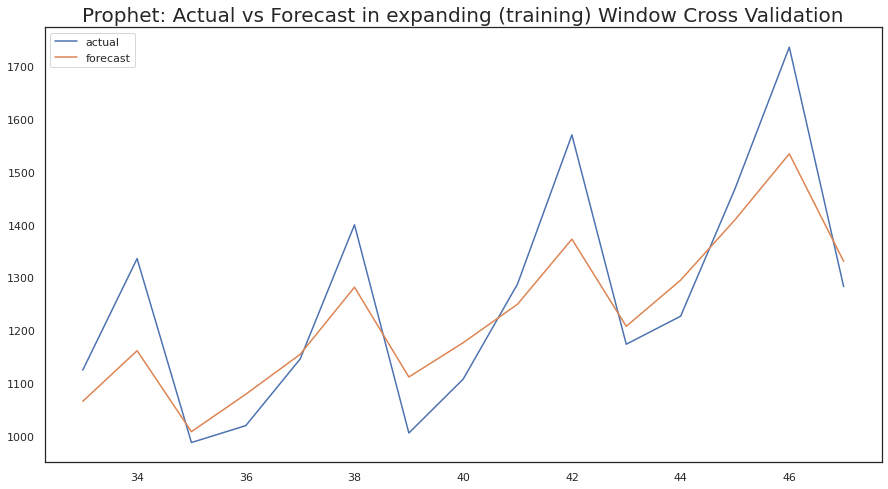

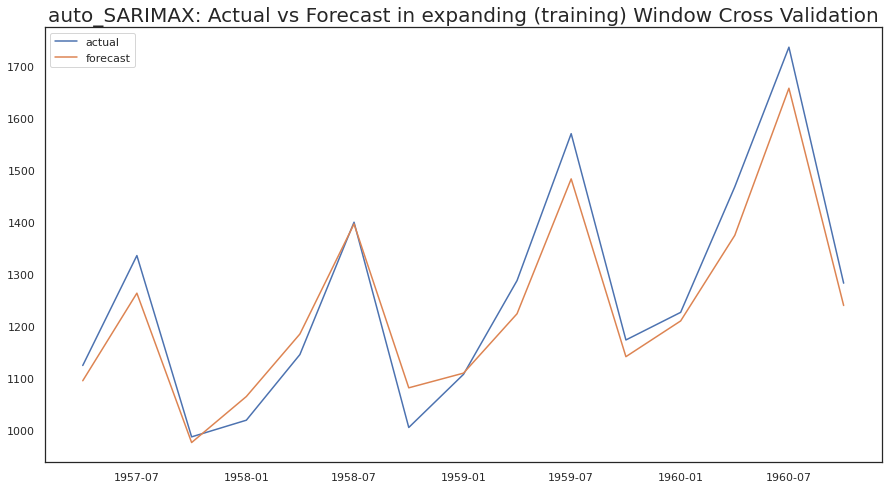

In [12]:
model.fit(
    traindata=dataset,
    ts_column=ts_column,
    target=target,
    cv=3,
    sep=sep,
)

## Evaluate Results

In [13]:
model.get_leaderboard()

,name,rmse
1,auto_SARIMAX,54.437910
0,Prophet,102.598272
2,VAR,inf
3,ML,inf


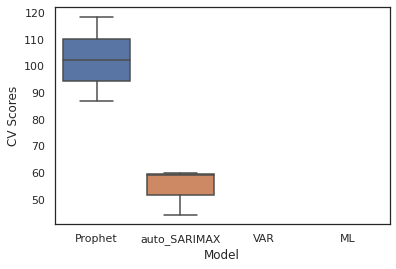

In [14]:
model.plot_cv_scores()

In [15]:
# Make sure all models have the same number of CV folds
model.get_cv_scores()

,Model,CV Scores
0,Prophet,87.046287
1,Prophet,118.549995
2,Prophet,102.198534
3,auto_SARIMAX,44.285361
4,auto_SARIMAX,58.991585
5,auto_SARIMAX,60.036786
6,VAR,inf
7,ML,inf


In [16]:
results_dict = model.get_ml_dict()

In [17]:
results_dict["Prophet"]["forecast"]

array([1065.92976775, 1161.73671128, 1008.60570975, 1079.37869573,
       1154.82436038, 1281.92964327, 1111.99496836, 1176.9010274 ,
       1249.75309589, 1372.80774161, 1207.94421838, 1295.20025005,
       1409.35438975, 1534.28943881, 1330.88276452])

In [18]:
results_dict["auto_SARIMAX"]["forecast"]

[array([1095.70719325, 1263.83980655,  977.11697391, 1065.45625118,
        1185.44734263]),
 array([1396.69312974, 1082.13846312, 1110.33516484, 1224.33388511,
        1483.20594874]),
 array([1141.93920026, 1210.51551224, 1374.81894336, 1657.21840958,
        1240.18415414])]

In [19]:
results_dict["ML"]

defaultdict(<function auto_ts.auto_timeseries.fit.<locals>.<lambda>>,
            {'forecast': None,
             'model': None,
             'model_build': <auto_ts.models.build_ml.BuildML at 0x7fb580a8a290>,
             'rmse': inf})

In [20]:
dataset.tail()

,Month,Passengers
43,1959-10-01,1174
44,1960-01-01,1227
45,1960-04-01,1468
46,1960-07-01,1736
47,1960-10-01,1283


## Forecast Results

In [21]:
# Using Best Model
future_predictions = model.predict(testdata=FORECAST_PERIOD)
future_predictions

Passengers,yhat,mean_se,mean_ci_lower,mean_ci_upper
1961-01-01,1307.675636,25.801659,1257.105313,1358.245959
1961-04-01,1606.310571,28.570206,1550.313997,1662.307145
1961-07-01,1907.874410,34.263425,1840.719331,1975.029488
1961-10-01,1399.993047,34.279719,1332.806032,1467.180061
1962-01-01,1396.155960,43.159019,1311.565838,1480.746083


In [22]:
# Using specific model
future_predictions = model.predict(testdata=FORECAST_PERIOD, model="auto_SARIMAX")
future_predictions

Passengers,yhat,mean_se,mean_ci_lower,mean_ci_upper
1961-01-01,1307.675636,25.801659,1257.105313,1358.245959
1961-04-01,1606.310571,28.570206,1550.313997,1662.307145
1961-07-01,1907.874410,34.263425,1840.719331,1975.029488
1961-10-01,1399.993047,34.279719,1332.806032,1467.180061
1962-01-01,1396.155960,43.159019,1311.565838,1480.746083


In [23]:
# Using specific model
future_predictions = model.predict(
    testdata=FORECAST_PERIOD,
    model="Prophet",
    simple=False,
)
future_predictions

Building Forecast dataframe. Forecast Period = 2


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
48,1961-01-01,4351.438223,1371.281312,1515.942771,4351.363564,4351.534201,-2910.721605,-2910.721605,-2910.721605,-2910.721605,-2910.721605,-2910.721605,0.0,0.0,0.0,1440.716618
49,1961-04-01,4377.810167,1453.278048,1596.519604,4377.478218,4378.213748,-2855.307228,-2855.307228,-2855.307228,-2855.307228,-2855.307228,-2855.307228,0.0,0.0,0.0,1522.502939
